For Bengali language you need to have Bengali Natural Language Processing toolkit installed (was used for sentence split). You can install it using pip as in the cell below. 

In [1]:
lang = 'bengali'
!pip install bnlp_toolkit

In [2]:
from importlib import reload
import preprocessing

preprocessing = reload(preprocessing)

preprocessing.data_preparation_bengali('data/bengali_corpus.txt')

/home/daniyar/miniconda3/envs/snlp/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


number of unique characters - 155  
number of unique words - 40363  
number of words - 198299

In [3]:
%cd {lang}/corpus
for VOCAB_SIZE in [155, 700, 5000]:
    !spm_train --input=train.txt --model_prefix=model_{VOCAB_SIZE} --vocab_size={VOCAB_SIZE} --character_coverage=1.0 --model_type=bpe
    !spm_encode --model=model_{VOCAB_SIZE}.model --output_format=piece < train.txt > train{VOCAB_SIZE}.txt
    !spm_encode --model=model_{VOCAB_SIZE}.model --output_format=piece < test.txt > test{VOCAB_SIZE}.txt
%cd ..
%cd ..

/home/daniyar/snlp/project/bengali/corpus
sentencepiece_trainer.cc(79) LOG(INFO) Starts training with : 
trainer_spec {
  input: train.txt
  input_format: 
  model_prefix: model_700
  model_type: BPE
  vocab_size: 700
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_white

## 3 LM Training

### Baseline/Best models

In [4]:
for VOCAB_SIZE in [155, 700, 5000]:
    %mkdir --parents {lang}/models/m{VOCAB_SIZE}
    !rnnlm/rnnlm -train {lang}/corpus/train{VOCAB_SIZE}.txt -valid {lang}/corpus/test{VOCAB_SIZE}.txt -rnnlm {lang}/models/m{VOCAB_SIZE}/rnn_baseline -hidden 40 -rand-seed 1 -debug 2 -bptt 3 -class {VOCAB_SIZE} | tee {lang}/models/m{VOCAB_SIZE}/rnn_baseline.log

debug mode: 2
train file: bengali/corpus/train700.txt
valid file: bengali/corpus/test700.txt
class size: 700
Hidden layer size: 40
BPTT: 3
Rand seed: 1
rnnlm file: bengali/models/m700/rnn_baseline
Starting training using file bengali/corpus/train700.txt
Vocab size: 698
Words in train file: 468364
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 7.6382    Words/sec: 27911.5   VALID entropy: 7.0080
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 6.7600    Words/sec: 28398.9   VALID entropy: 6.7789
Iter:   2	Alpha: 0.100000	   TRAIN entropy: 6.5982    Words/sec: 28311.4   VALID entropy: 6.7004
Iter:   3	Alpha: 0.100000	   TRAIN entropy: 6.5214    Words/sec: 28378.2   VALID entropy: 6.6459
Iter:   4	Alpha: 0.100000	   TRAIN entropy: 6.4738    Words/sec: 27878.4   VALID entropy: 6.6113
Iter:   5	Alpha: 0.100000	   TRAIN entropy: 6.4410    Words/sec: 28319.9   VALID entropy: 6.5961
Iter:   6	Alpha: 0.050000	   TRAIN entropy: 6.3222    Words/sec: 28304.1   VALID entropy: 6.4816
Iter:   7	Alpha: 0.0250

vocabulary of size 155 -> perplexity 8.770176
vocabulary of size 700 -> perplexity 81.093574
vocabulary of size 5000 -> perplexity 576.671790

## **4 Text Generation**

In [11]:
for VOCAB_SIZE in [155, 700, 5000]:
    %mkdir --parents {lang}/generated/m{VOCAB_SIZE}
    for i in range(1, 8):
        print(10**i, flush=True)
        !rnnlm/rnnlm -rnnlm {lang}/models/m{VOCAB_SIZE}/rnn_best -gen {10**i} -debug 0 > {lang}/generated/m{VOCAB_SIZE}/{10**i}.txt
        !spm_decode --model={lang}/corpus/model_{VOCAB_SIZE}.model --input_format=piece < {lang}/generated/m{VOCAB_SIZE}/{10**i}.txt > {lang}/generated/m{VOCAB_SIZE}/{10**i}_decoded.txt

10
100
1000
10000
100000
1000000
10000000


## 5 OOV comparison

### Original corpus

In [6]:
import oov
import codecs
import numpy as np
oov = reload(oov)

In [7]:
train = []
test = []
with codecs.open("{}/corpus/train.txt".format(lang), encoding='utf-8') as f:
    for line in f:
        train += line.split()
with codecs.open("{}/corpus/test.txt".format(lang), encoding='utf-8') as f:
    for line in f:
        test += line.split()

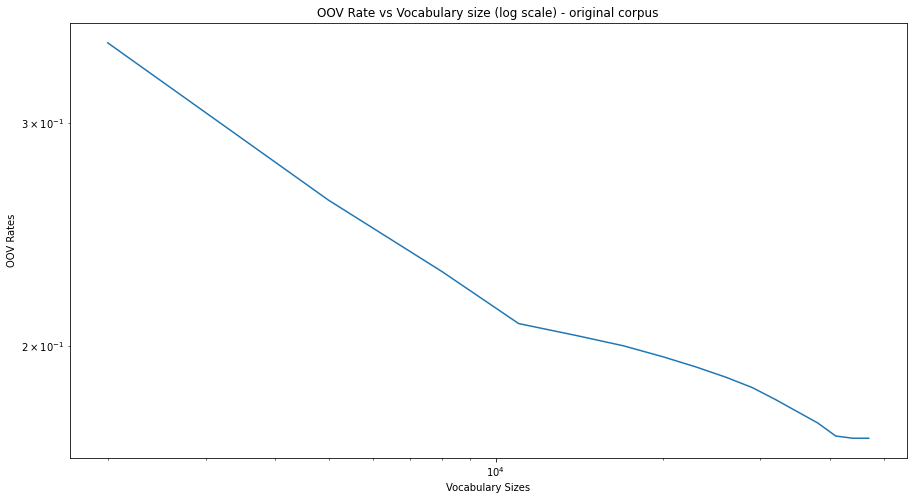

In [8]:
oov = reload(oov)
voc_sizes = np.arange(2000, 47000+1, 3000)
oov_rates = oov.get_oov_rates(train, test, voc_sizes)
oov.plot_oov_rates(oov_rates, voc_sizes, 'OOV Rate vs Vocabulary size (log scale) - original corpus')

In [9]:
print(oov_rates)

[0.3466325542801825, 0.26056216290969436, 0.2289621075923109, 0.20832180887844004, 0.20382727147005947, 0.20007606140229567, 0.19616927119347255, 0.1925044945374084, 0.18899529802240353, 0.1854861015073987, 0.18140644447517631, 0.1774996542663532, 0.1740077444336883, 0.16987622735444613, 0.16920204674318906, 0.16920204674318906]


### Generated corpora

In [12]:
oov = reload(oov)
test = []
with codecs.open("{}/corpus/test.txt".format(lang), encoding='utf-8') as f:
    for line in f:
        test += line.split()

voc_sizes = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
results = {}
for model in ['m155', 'm700', 'm5000']:
    oov_rates = []
    for voc_size in voc_sizes:
        train = []
        with codecs.open("{}/generated/{}/{}_decoded.txt".format(lang, model, str(voc_size)), encoding='utf-8') as f:
            for line in f:
                train += line.split()
        oov_rate = oov.get_oov_rate(train, test)
        oov_rates.append(oov_rate)
        print(oov_rate)
    print('-----')
    results[model] = tuple(oov_rates)

0.9974934310607109
0.983560365094731
0.8609286405753008
0.654871387083391
0.49579933619139815
0.3890713594246992
0.30874014659106624
-----
0.9977700179781497
0.9645277278384733
0.7628267182962246
0.5232333010648597
0.38507813580417644
0.30262066104273266
0.24068247821878025
-----
0.9810883695201217
0.9207924215184622
0.7122285990872632
0.46221131240492325
0.3253180749550546
0.2608560365094731
0.20783778177292214
-----


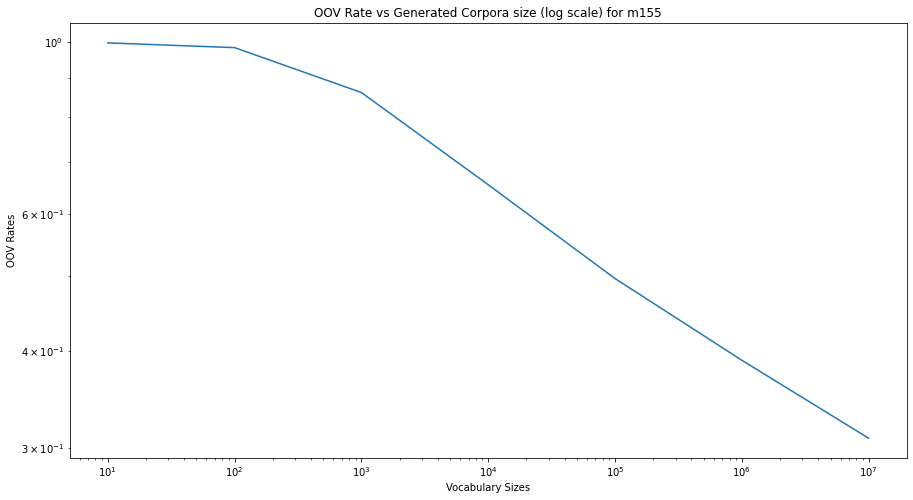

In [13]:
model = 'm155'
oov.plot_oov_rates(results[model], voc_sizes, 'OOV Rate vs Generated Corpora size (log scale) for {}'.format(model))

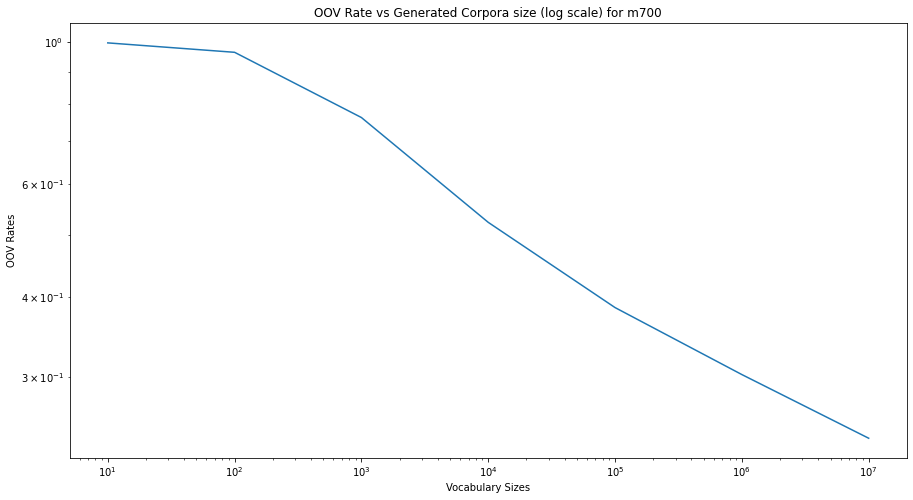

In [14]:
model = 'm700'
oov.plot_oov_rates(results[model], voc_sizes, 'OOV Rate vs Generated Corpora size (log scale) for {}'.format(model))

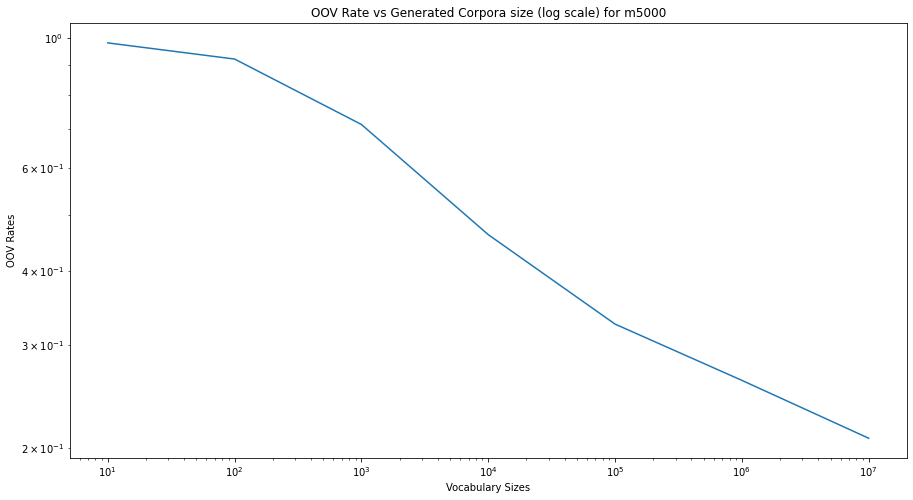

In [15]:
model = 'm5000'
oov.plot_oov_rates(results[model], voc_sizes, 'OOV Rate vs Generated Corpora size (log scale) for {}'.format(model))